# BM4D Experiment

In [5]:
import os
import json
import time

import bm4d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

import h5py

from tqdm.notebook import tqdm


## Load dataset

In [12]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)



Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4927044212818146); std:0.022372599691152573
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -24.626427916933984, 'noise_max': 25.3497884510521}


## Example denoising 

noisy_image: dtype:float32 range(0.40103206038475037,0.9798246026039124) mean:0.4923691749572754 std:0.021632032468914986
denoised_image: dtype:float64 range(0.41016048192977905,0.9690738320350647) mean:0.4923675729459574 std:0.019124836262095008
calculate_metrics running: 2.4658027216792107 second
PSNR: 35.537354562607355; SSIM: 0.7750971120767053; MAE: 0.0077167367911191624; BRISQUE: 111.96531863541311


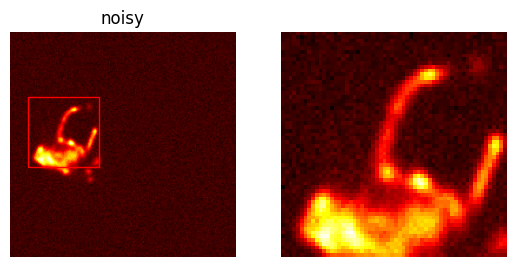

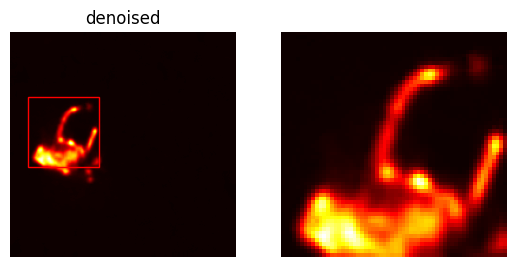

In [14]:
# demonstrate 
time_idx = 11
depth_idx = 38


#
noisy_image = noisy_data[0, time_idx]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# process denoising
noise_level = 0.01 # set noise level 

denoised_image = bm4d.bm4d(noisy_image, noise_level)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# calculate PSNR, SSIM and MAE
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range = max(data_range_denoised, data_range_noisy)
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_image, noisy_image, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.mean(mae_values)}; BRISQUE: {np.mean(brisque_values)}")


# show result
zoom_coordinates = (55, 15, 60, 60)
display_image_in_detail(noisy_image[depth_idx], title='noisy')
display_image_in_detail(denoised_image[depth_idx], title='denoised')

## Process denoising

In [ ]:
# denoised 
@timer_decorator
def process(noisy_data, noise_level):
    denoised_data = np.zeros_like(noisy_data)
    with tqdm(total=noisy_data.shape[0]) as pbar:
        for i in range(noisy_data.shape[0]):
            sub_image = noisy_data[i, :, :, :]
            denoised_sub_image = bm4d.bm4d(sub_image, noise_level)
            denoised_data[i, :, :, :] = denoised_sub_image
            pbar.update(1)
    return denoised_data


denoised_data = process(noisy_data[0], noise_level)
            
print(f"denoised_data: dtype:{denoised_data.dtype} range({np.min(denoised_data)},{np.max(denoised_data)}) mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

## Evaluation

Calculate PSNR, SSIM

In [ ]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_data) - np.min(noisy_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, noisy_data, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.mean(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

## Save denormalized denoised image into int16 DICOM file

In [ ]:
# denormalzied denoised data
mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_4d_image(denormalized_denoised_data)

In [ ]:
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_gauss_0.009'

save_4d_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)